In [43]:
import tensorflow as tf
from tensorflow.keras import layers, models , initializers
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.optimizers import legacy
import pandas as pd
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# load data

In [44]:
def load_images_from_dir(directory, target_size=(320, 320)):
    image_list = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(directory, filename)
            # Load the image using OpenCV
            image = cv2.imread(image_path)
            if image is None:
                print(f"Warning: Unable to load image '{filename}'")
                continue
            
            # Convert BGR to RGB format
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Resize the image
            resized_image = cv2.resize(image_rgb, target_size)
            image_list.append(resized_image)
    return image_list



In [45]:
directory_path = "data/monet_jpg/"
monet_image_list = load_images_from_dir(directory_path)
print("Number of images loaded:", len(monet_image_list))

Number of images loaded: 300


In [46]:
directory_path = "data/photo_jpg/"
image_list = load_images_from_dir(directory_path)
print("Number of images loaded:", len(image_list))

Number of images loaded: 7038


# EDA images

In [47]:
def plot_random_images(image_list):
    # Ensure that we have at least 5 images
    if len(image_list) < 5:
        print("Error: Insufficient number of images.")
        return
    
    # Choose 5 random indices
    random_indices = random.sample(range(len(image_list)), 5)
    
    # Plot the images
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i, idx in enumerate(random_indices):
        axes[i].imshow(image_list[idx])  # Convert BGR to RGB for Matplotlib
        axes[i].axis('off')
        axes[i].set_title(f"Image {idx}")
    plt.show()


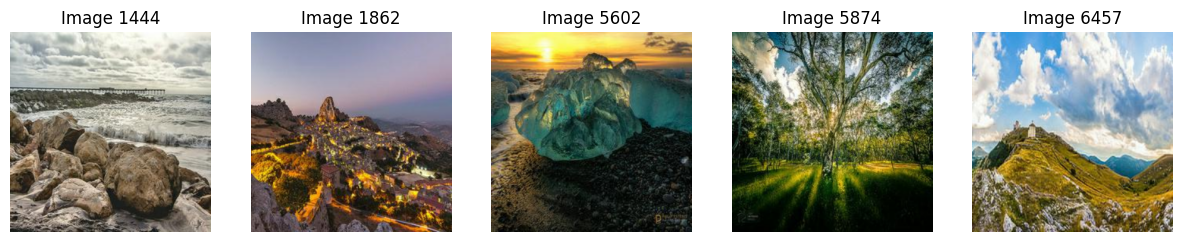

In [48]:
plot_random_images(image_list)

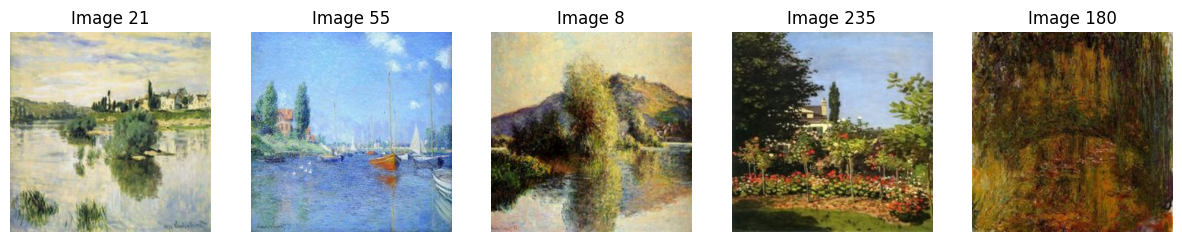

In [49]:
plot_random_images(monet_image_list)

# cleaning the data

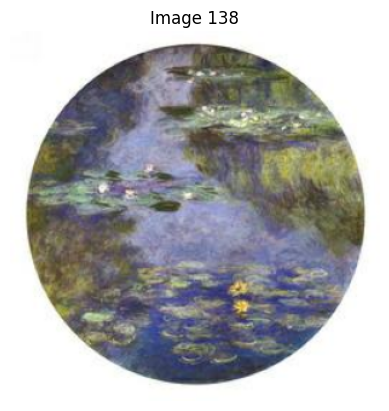

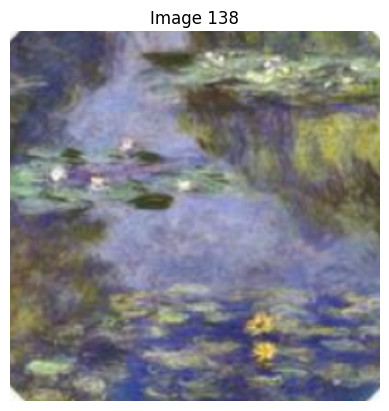

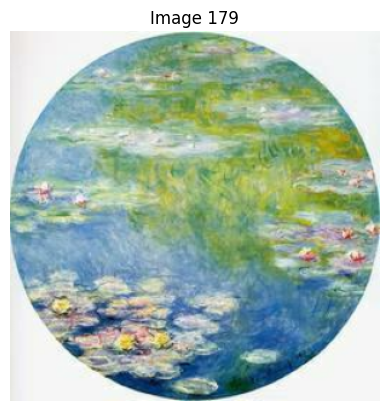

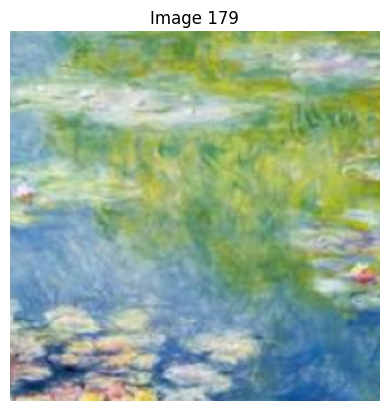

In [50]:
def has_white_corner(image):
    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Define the size of the corner region
    corner_size = 5
    
    # Define the four corners
    corners = [
        gray_image[:corner_size, :corner_size],                # Top-left corner
        gray_image[:corner_size, -corner_size:],              # Top-right corner
        gray_image[-corner_size:, :corner_size],              # Bottom-left corner
        gray_image[-corner_size:, -corner_size:]              # Bottom-right corner
    ]
    
    # Check if all corners are completely white
    return all(np.all(corner > 220) for corner in corners)

def crop_and_resize(image, target_size=(320, 320)):
    # Get the dimensions of the input image
    height, width = image.shape[:2]
    
    # Calculate the center coordinates
    center_x = width // 2
    center_y = height // 2
    
    # Calculate the crop boundaries
    crop_left = max(0, center_x - 215 // 2)
    crop_top = max(0, center_y - 215 // 2)
    crop_right = min(width, center_x + 215 // 2)
    crop_bottom = min(height, center_y + 215 // 2)
    
    # Crop the image
    cropped_image = image[crop_top:crop_bottom, crop_left:crop_right]
    
    # Resize the cropped image
    resized_image = cv2.resize(cropped_image, target_size)
    
    return resized_image

def show_images_with_white_corner(images):
    for idx, image in enumerate(images):
        if has_white_corner(image):
            cropped_resized_image = crop_and_resize(image)
            plt.imshow(image)
            plt.title(f"Image {idx}")
            plt.axis('off')
            plt.show()

            plt.imshow(cropped_resized_image)
            plt.title(f"Image {idx}")
            plt.axis('off')
            plt.show()


show_images_with_white_corner(monet_image_list)

In [51]:
def change_images_with_white_corner(images):
    new_images = []
    for idx, image in enumerate(images):
        if has_white_corner(image):
            new_images.append(crop_and_resize(image))
        else:
            new_images.append(image)

    return new_images

monet_image_list = change_images_with_white_corner(monet_image_list)

# AUGMENTATION

In [52]:
def split_and_resize_quarters(original_image):
    # Convert PIL Image to NumPy array
    original_image_array = np.array(original_image)
    
    # Ensure the image is 320x320
    if original_image_array.shape[:2] != (320, 320):
        print("Error: Image size must be 320x320.")
        return None
    
    
    # Split the image into quarters
    quarters = []
    for i in range(2):
        for j in range(2):
            left = j * 160
            upper = i * 160
            right = left + 160
            lower = upper + 160
            quarter = original_image_array[upper:lower, left:right, :]
            quarters.append(quarter)
    
    # Resize each quarter to 320x320
    resized_quarters = [cv2.resize(quarter, (320, 320)) for quarter in quarters]
    
    return original_image , resized_quarters

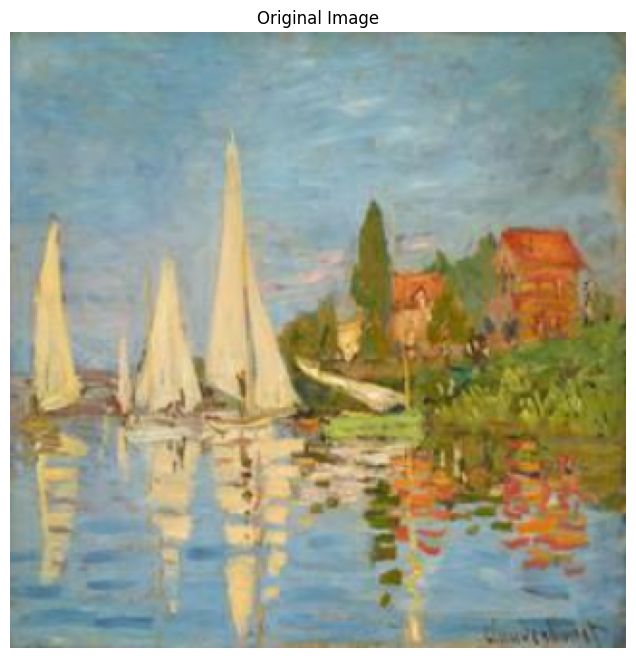

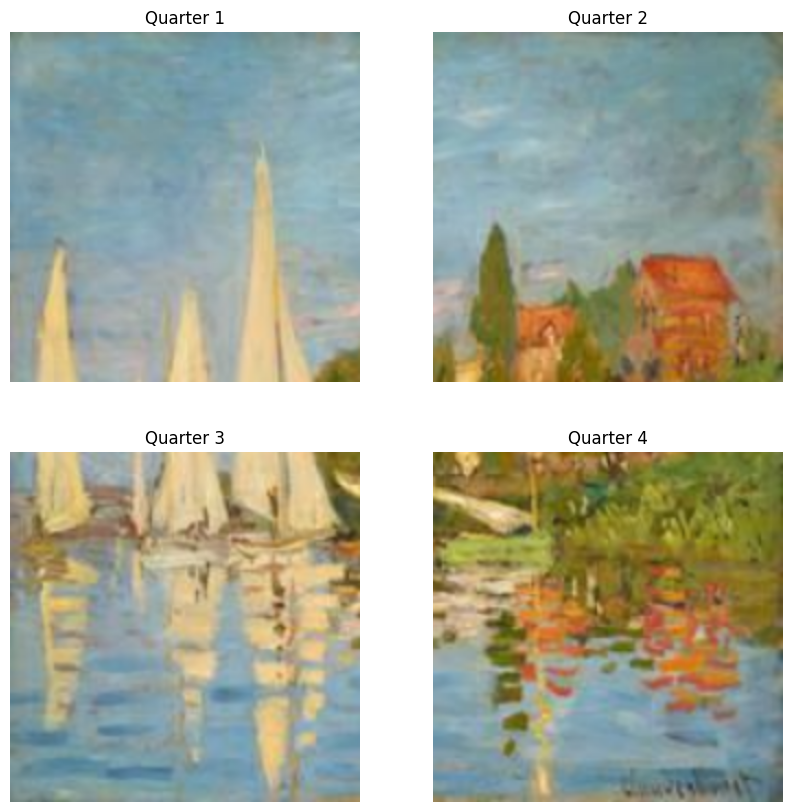

In [53]:
original_image, quarters = split_and_resize_quarters(monet_image_list[0])
if quarters:
    # Plot original image
    plt.figure(figsize=(8, 8))
    plt.imshow(original_image)
    plt.axis('off')
    plt.title("Original Image")
    plt.show()
    
    # Plot each quarter
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for i, quarter in enumerate(quarters):
        axes[i//2, i%2].imshow(quarter)
        axes[i//2, i%2].axis('off')
        axes[i//2, i%2].set_title(f"Quarter {i+1}")
    plt.show()

In [54]:
def get_images_with_high_color_variance(images, threshold):
    high_color_var_images = []
    
    for image in images:
        # Convert image to numpy array
        image_array = np.array(image)
        
        # Calculate color variance
        color_variance = np.var(image_array)
        # Check if color variance is higher than the threshold
        if color_variance > threshold:
            high_color_var_images.append(image)
    
    return high_color_var_images

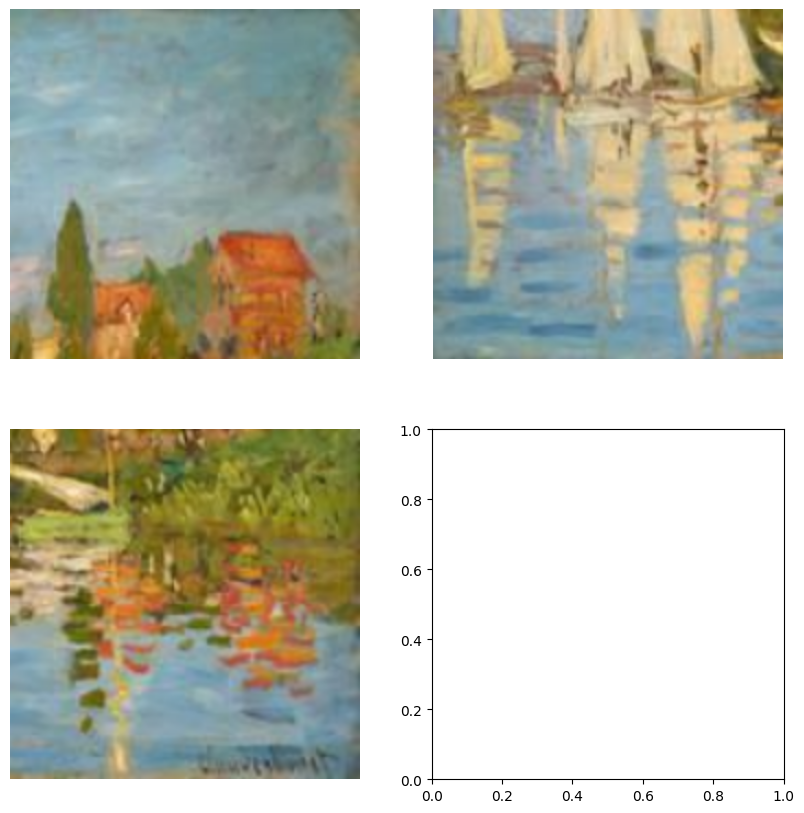

In [55]:
most_colorful_image = get_images_with_high_color_variance(quarters , 1000)
if most_colorful_image:
    # Plot each quarter
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for i, quarter in enumerate(most_colorful_image):
        axes[i//2, i%2].imshow(quarter)
        axes[i//2, i%2].axis('off')
    plt.show()

In [56]:
def mirror_flip(image):
    # Mirror flip the image horizontally
    flipped_image = cv2.flip(image, 1)
    return flipped_image


def aug_pipeline(images, threshold):
    augmented_images = []
    
    for image in images:
        # Split into quarters
        _ , quarters = split_and_resize_quarters(image)
        
        # Save only important quarters
        important_quarters = get_images_with_high_color_variance(quarters, threshold)

        # Mirror flip the original image
        mirrored_image = mirror_flip(image)
                
        # Combine original image, mirrored image, and important quarters
        augmented_images.append(image)
        augmented_images.append(mirrored_image)
        if len(important_quarters) != 0:
            augmented_images.extend(important_quarters)
    
    return augmented_images

300
1558


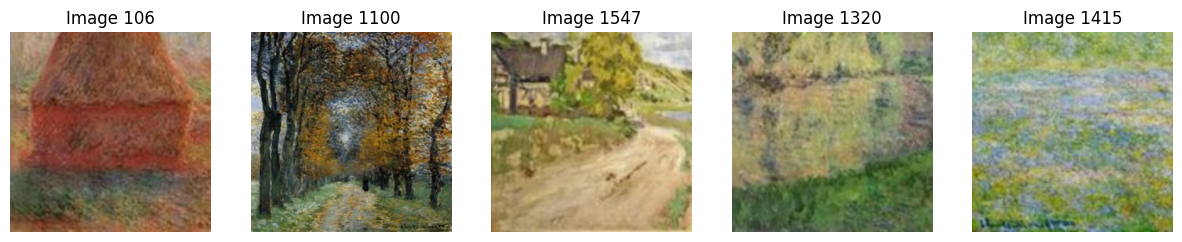

In [57]:
print(len(monet_image_list))
augmented_images = aug_pipeline(monet_image_list, 1000)
print(len(augmented_images))
plot_random_images(augmented_images)

# save the data in batch for model

In [58]:
# for debug
# augmented_images = augmented_images[:50]
# image_list = image_list[:100]

In [59]:
def decode_image(image):
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [320,320, 3])
    return image


def encode_image(image):
    # Reverse normalization: Convert pixel values from range [-1, 1] to [0, 255]
    image = (image + 1) * 127.5
    
    # Ensure pixel values are within valid range [0, 255]
    image = tf.clip_by_value(image, 0, 255)
    
    # Convert pixel values to uint8 data type
    image = tf.cast(image, tf.uint8)
    
    return image



In [60]:
image_list = random.sample(image_list, len(augmented_images))

In [61]:
# Define batch size
BATCH_SIZE = 10 # need to select the batch size based on the gpu

monet_len, real_len = len(augmented_images), len(image_list)
decoded_monet_images = [decode_image(image) for image in augmented_images]
decoded_real_images = [decode_image(image) for image in image_list]
print(len(decoded_monet_images) ,monet_len )
print(len(decoded_real_images) , real_len)




# Correct the slicing for augmented_images to split into train, val, and test sets
train_monet = decoded_monet_images[:int(0.8 * monet_len)]
val_monet = decoded_monet_images[int(0.8 * monet_len):int(0.9 * monet_len)]
test_monet = decoded_monet_images[int(0.9 * monet_len):]

# Correct the slicing for image_list to split into train, val, and test sets
train_real = decoded_real_images[:int(0.8 * real_len)]
val_real = decoded_real_images[int(0.8 * real_len):int(0.9 * real_len)]
test_real = decoded_real_images[int(0.9 * real_len):]


# Convert lists to TensorFlow datasets
train_real = tf.data.Dataset.from_tensor_slices(train_real)
val_real = tf.data.Dataset.from_tensor_slices(val_real)
test_real = tf.data.Dataset.from_tensor_slices(test_real)

train_monet = tf.data.Dataset.from_tensor_slices(train_monet)
val_monet = tf.data.Dataset.from_tensor_slices(val_monet)
test_monet = tf.data.Dataset.from_tensor_slices(test_monet)



# Train Dataset
train_dataset = tf.data.Dataset.zip((train_real ,train_monet))
test_dataset = tf.data.Dataset.zip((test_real ,test_monet))
val_dataset = tf.data.Dataset.zip((val_real , val_monet))


# Optionally shuffle and batch the dataset
train_dataset = train_dataset.shuffle(buffer_size=len(train_real)).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

50 50
50 50


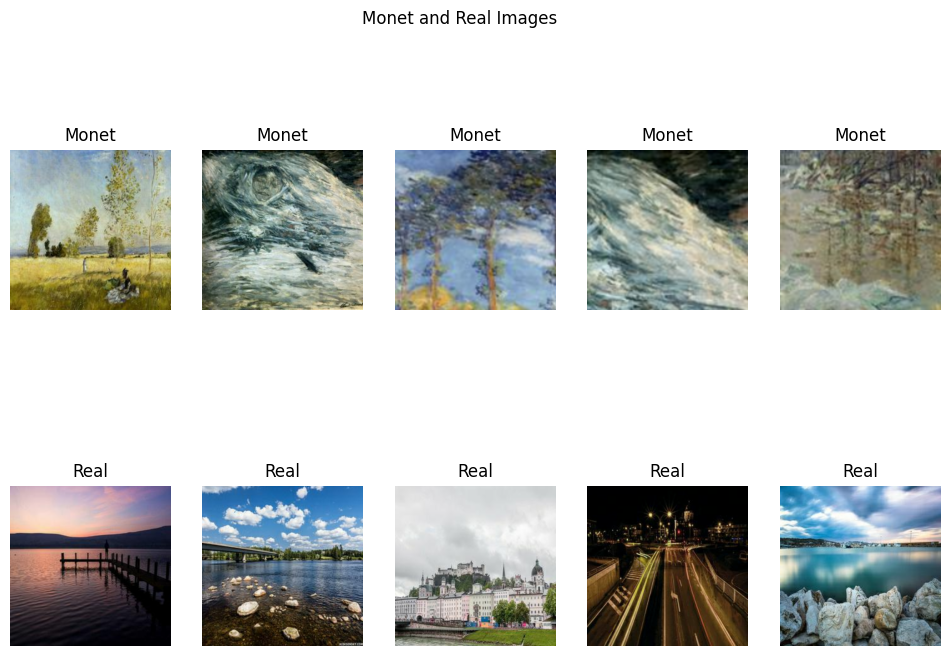

In [62]:
import matplotlib.pyplot as plt
import tensorflow as tf

def plot_images_from_batch(dataset, title, img_to_plot=10):
    # Fetch one batch of images
    for real_batch ,monet_batch in dataset.take(1):  # Just take one batch from the dataset
        plt.figure(figsize=(12, 8))

        for i in range(img_to_plot):
            # Plot Monet images
            plt.subplot(2, img_to_plot, i + 1)
            monet_image = encode_image(monet_batch[i])
            plt.imshow(monet_image)
            plt.title("Monet")
            plt.axis("off")

            # Plot Real images, adjust subplot index to move to the next row
            plt.subplot(2, img_to_plot, i + 1 + img_to_plot)
            real_image = encode_image(real_batch[i])
            plt.imshow(real_image)
            plt.title("Real")
            plt.axis("off")

        plt.suptitle(title)
        plt.show()

# Example usage:
plot_images_from_batch(train_dataset, "Monet and Real Images", img_to_plot=5)


# create the objects that neccessary for the training

In [63]:

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result


sample, _ = next(iter(train_dataset))  # Assuming batch size of 1
sample_float32 = tf.cast(sample, tf.float32)

down_model = downsample(3, 4)
down_result = down_model(sample_float32)
print(down_result.shape)

(10, 160, 160, 3)


In [64]:

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result
     


up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(10, 320, 320, 3)


In [65]:


# Define Generator model
def Generator():
  inputs = tf.keras.layers.Input(shape=[320, 320, 3])
  
  down_stack = [
    downsample(80, 4, apply_batchnorm=False),  # (batch_size, 160, 160, 80)
    downsample(160, 4),  # (batch_size, 64, 64, 128)
    downsample(320, 4),  # (batch_size, 32, 32, 256)
    downsample(640, 4),  # (batch_size, 16, 16, 512)
    downsample(640, 4),  # (batch_size, 8, 8, 512)
    downsample(640, 4),  # (batch_size, 4, 4, 512)
    # downsample(640, 4),  # (batch_size, 2, 2, 512)
    # downsample(640, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    # upsample(640, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    # upsample(640, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(640, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(640, 4 ,apply_dropout=True),  # (batch_size, 16, 16, 1024)
    upsample(320, 4),  # (batch_size, 32, 32, 512)
    upsample(160, 4),  # (batch_size, 64, 64, 256)
    upsample(80, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)



  x = inputs


  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)
     


  return tf.keras.Model(inputs=inputs, outputs=x)

# Test the generator model with random input batch
def test_build_generator():


    # Build generator model
    generator = Generator()
    

    input_shape = (320, 320, 3)  # Example input shape
    # Generate a random batch of input images
    batch_size = 4
    random_input_batch = tf.random.uniform((batch_size,) + input_shape, minval=0, maxval=1)
    
    # Forward pass through the generator
    generated_images = generator(random_input_batch)
    print(generator.summary())

    # Check output shape
    output_shape = generated_images.shape
    expected_output_shape = (batch_size, 320, 320, 3)  # Output shape with batch dimension
    
    # Check if the output shape matches the expected output shape
    assert output_shape == expected_output_shape, "Output shape mismatch"
    print("Test passed!")

# Run the test
test_build_generator()

Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_27 (InputLayer)       [(None, 320, 320, 3)]        0         []                            
                                                                                                  
 sequential_191 (Sequential  (None, 160, 160, 80)         3840      ['input_27[0][0]']            
 )                                                                                                
                                                                                                  
 sequential_192 (Sequential  (None, 80, 80, 160)          205440    ['sequential_191[0][0]']      
 )                                                                                                
                                                                                           

In [66]:
# Define Discriminator model
def Discriminator(input_nc = 3, ndf=80, n_layers=3):
    inputs = tf.keras.layers.Input(shape=(320, 320, input_nc))
    x = inputs
    nf_mult_prev = 1

    # First convolutional layer
    x = tf.keras.layers.Conv2D(ndf, kernel_size=4, strides=2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    nf_mult = 1
    # Middle convolutional layers
    for n in range(1, n_layers):
        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n, 5)
        x = tf.keras.layers.Conv2D(ndf * nf_mult, kernel_size=4, strides=2, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(0.2)(x)

    # Last convolutional layer
    nf_mult_prev = nf_mult
    nf_mult = min(2 ** n_layers, 5)
    x = tf.keras.layers.Conv2D(ndf * nf_mult, kernel_size=4, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    # Output convolutional layer
    outputs = tf.keras.layers.Conv2D(1, kernel_size=4, strides=1, padding='same')(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

# Test the discriminator model with random input batch
def test_build_discriminator():
    # Define input shape
    input_shape = (320, 320, 3)  # Example input shape

    # Build discriminator model
    discriminator = Discriminator(3)
    
    # Generate a random batch of input images
    batch_size = 4
    random_input_batch = tf.random.uniform((batch_size,) + input_shape, minval=0, maxval=1)
    
    # Forward pass through the discriminator
    discriminator_output = discriminator(random_input_batch)
    
    # Check output shape
    output_shape = discriminator_output.shape
    print(output_shape)
    print(discriminator.summary())
    expected_output_shape = (batch_size, 40, 40, 1)  # Output shape with batch dimension
    
    # Check if the output shape matches the expected output shape
    assert output_shape == expected_output_shape, "Output shape mismatch"
    print("Test passed!")

# Run the test
test_build_discriminator()

(4, 40, 40, 1)
Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 320, 320, 3)]     0         
                                                                 
 conv2d_155 (Conv2D)         (None, 160, 160, 80)      3920      
                                                                 
 leaky_re_lu_146 (LeakyReLU  (None, 160, 160, 80)      0         
 )                                                               
                                                                 
 conv2d_156 (Conv2D)         (None, 80, 80, 160)       204960    
                                                                 
 batch_normalization_211 (B  (None, 80, 80, 160)       640       
 atchNormalization)                                              
                                                                 
 leaky_re_lu_147 (LeakyReLU  (None, 80, 80,

In [67]:
class CycleGan(tf.keras.Model):
    def __init__(self, generator_real2monet, generator_monet2real, discriminator_real, discriminator_monet, lr=5e-4, beta_1=0.5):
        super(CycleGan, self).__init__()
        self.generator_real2monet = generator_real2monet
        self.generator_monet2real = generator_monet2real
        self.discriminator_real = discriminator_real
        self.discriminator_monet = discriminator_monet
        self.lr = lr
        self.beta_1 = beta_1
        
    def compile(self, mac=True):
        if mac:
            optimizer = legacy.Adam(learning_rate=self.lr, beta_1=self.beta_1)
        else:
            optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr, beta_1=self.beta_1)
            
        self.generator_real2monet.compile(optimizer=optimizer)
        self.generator_monet2real.compile(optimizer=optimizer)
        self.discriminator_real.compile(optimizer=optimizer)
        self.discriminator_monet.compile(optimizer=optimizer)
        
    def adversarial_loss(self, discriminator, generated):
        fake_output = discriminator(generated)
        return tf.reduce_mean(tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output))
    
    def cycle_consistency_loss(self, real_images, reconstructed_images):
        return tf.reduce_mean(tf.abs(real_images - reconstructed_images))
    
    def discriminator_loss(self, real_output, fake_output):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
        fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss
    
    def train_step(self, batch_data):
        batch_real, batch_monet = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # Generate fake images
            fake_monet = self.generator_real2monet(batch_real, training=True)
            fake_real = self.generator_monet2real(batch_monet, training=True)

            # Generate reconstructed images
            reconstr_real = self.generator_monet2real(fake_monet, training=True)
            reconstr_monet = self.generator_real2monet(fake_real, training=True)

            # Adversarial loss
            adv_loss_R2M = self.adversarial_loss(self.discriminator_monet, fake_monet)
            adv_loss_M2R = self.adversarial_loss(self.discriminator_real, fake_real)

            # Cycle consistency loss
            cycle_loss = self.cycle_consistency_loss(batch_real, reconstr_real) + \
                         self.cycle_consistency_loss(batch_monet, reconstr_monet)

            # Total generator loss
            total_gen_R2M_loss = adv_loss_R2M + cycle_loss
            total_gen_M2R_loss = adv_loss_M2R + cycle_loss

            # Compute discriminator losses
            disc_real_real_output = self.discriminator_real(batch_real, training=True)
            disc_real_fake_output = self.discriminator_real(fake_real, training=True)
            disc_monet_real_output = self.discriminator_monet(batch_monet, training=True)
            disc_monet_fake_output = self.discriminator_monet(fake_monet, training=True)
            disc_real_loss = self.discriminator_loss(disc_real_real_output, disc_real_fake_output)
            disc_monet_loss = self.discriminator_loss(disc_monet_real_output, disc_monet_fake_output)
            
        # Compute gradients of generator loss with respect to generator variables
        gen_R2M_gradients = tape.gradient(total_gen_R2M_loss, self.generator_real2monet.trainable_variables)
        gen_M2R_gradients = tape.gradient(total_gen_M2R_loss, self.generator_monet2real.trainable_variables)

        # Apply gradients to generator variables
        self.generator_real2monet.optimizer.apply_gradients(zip(gen_R2M_gradients, self.generator_real2monet.trainable_variables))
        self.generator_monet2real.optimizer.apply_gradients(zip(gen_M2R_gradients, self.generator_monet2real.trainable_variables))

        # Compute gradients of discriminator losses with respect to discriminator variables
        disc_real_gradients = tape.gradient(disc_real_loss, self.discriminator_real.trainable_variables)
        disc_monet_gradients = tape.gradient(disc_monet_loss, self.discriminator_monet.trainable_variables)

        # Apply gradients to discriminator variables
        self.discriminator_real.optimizer.apply_gradients(zip(disc_real_gradients, self.discriminator_real.trainable_variables))
        self.discriminator_monet.optimizer.apply_gradients(zip(disc_monet_gradients, self.discriminator_monet.trainable_variables))

        return {
            "gen_R2M_loss": total_gen_R2M_loss,
            "gen_M2R_loss": total_gen_M2R_loss,
            "disc_real_loss": disc_real_loss,
            "disc_monet_loss": disc_monet_loss
        }
    
    def test_step(self, batch_data):
        batch_real, batch_monet = batch_data
        
        # Generate fake images
        fake_monet = self.generator_real2monet(batch_real, training=False)
        fake_real = self.generator_monet2real(batch_monet, training=False)

        # Generate reconstructed images
        reconstr_real = self.generator_monet2real(fake_monet, training=False)
        reconstr_monet = self.generator_real2monet(fake_real, training=False)

        # Adversarial loss
        adv_loss_R2M = self.adversarial_loss(self.discriminator_monet, fake_monet)
        adv_loss_M2R = self.adversarial_loss(self.discriminator_real, fake_real)

        # Cycle consistency loss
        cycle_loss = self.cycle_consistency_loss(batch_real, reconstr_real) + \
                    self.cycle_consistency_loss(batch_monet, reconstr_monet)

        # Total generator loss
        total_gen_R2M_loss = adv_loss_R2M + cycle_loss
        total_gen_M2R_loss = adv_loss_M2R + cycle_loss

        # Compute discriminator losses
        disc_real_real_output = self.discriminator_real(batch_real, training=False)
        disc_real_fake_output = self.discriminator_real(fake_real, training=False)
        disc_monet_real_output = self.discriminator_monet(batch_monet, training=False)
        disc_monet_fake_output = self.discriminator_monet(fake_monet, training=False)
        disc_real_loss = self.discriminator_loss(disc_real_real_output, disc_real_fake_output)
        disc_monet_loss = self.discriminator_loss(disc_monet_real_output, disc_monet_fake_output)

        return {
            "gen_R2M_loss": total_gen_R2M_loss,
            "gen_M2R_loss": total_gen_M2R_loss,
            "disc_real_loss": disc_real_loss,
            "disc_monet_loss": disc_monet_loss
        }

In [68]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [69]:
generator_real2monet, generator_monet2real = Generator(),Generator()
discriminator_real, discriminator_monet = Discriminator(),Discriminator()
lr = 5e-4
beta_1 = 0.5

models_folder = f"models/lr_{lr}_beta_{beta_1}"
os.makedirs(models_folder, exist_ok=True)
os.makedirs("results", exist_ok=True)
cycle_gan_model = CycleGan(generator_real2monet, generator_monet2real, discriminator_real, discriminator_monet, lr=lr, beta_1=beta_1)

# Compile the model
cycle_gan_model.compile()

num_epochs = 10
eval_interval = 2  

# Create an empty DataFrame to store training and evaluation metrics
log_data = {'Epoch': [], 
            'Gen R2M Loss Train': [], 'Gen M2R Loss Train': [], 
            'Disc Real Loss Train': [], 'Disc Monet Loss Train': [],
            'Gen R2M Loss Eval': [], 'Gen M2R Loss Eval': [], 
            'Disc Real Loss Eval': [], 'Disc Monet Loss Eval': []}

for epoch in range(1, num_epochs + 1):
    # Initialize tqdm for the training dataset
    train_losses = {'Gen R2M Loss': [], 'Gen M2R Loss': [], 'Disc Real Loss': [], 'Disc Monet Loss': []}

    for batch_real, batch_monet in tqdm(train_dataset, desc=f'Epoch {epoch}'):
        # Perform one training step
        train_logs = cycle_gan_model.train_step((batch_real, batch_monet))

        # Log training metrics
        train_losses['Gen R2M Loss'].append(train_logs['gen_R2M_loss'])
        train_losses['Gen M2R Loss'].append(train_logs['gen_M2R_loss'])
        train_losses['Disc Real Loss'].append(train_logs['disc_real_loss'])
        train_losses['Disc Monet Loss'].append(train_logs['disc_monet_loss'])

    # Calculate average training metrics
    avg_train_losses = {k + ' Train': np.mean(v) for k, v in train_losses.items()}
    
    cycle_gan_model.generator_real2monet.save_weights(os.path.join(models_folder, f'generator_real2monet_epoch_{epoch}.h5'))
    cycle_gan_model.generator_monet2real.save_weights(os.path.join(models_folder, f'generator_monet2real_epoch_{epoch}.h5'))
    cycle_gan_model.discriminator_real.save_weights(os.path.join(models_folder, f'discriminator_real_epoch_{epoch}.h5'))
    cycle_gan_model.discriminator_monet.save_weights(os.path.join(models_folder, f'discriminator_monet_epoch_{epoch}.h5'))
    
    # Evaluate the model every eval_interval epochs
    if epoch % eval_interval == 0:
        eval_metrics = {'Gen R2M Loss': 0.0, 'Gen M2R Loss': 0.0, 'Disc Real Loss': 0.0, 'Disc Monet Loss': 0.0}  # Initialize evaluation metrics
        num_batches = 0

        # Initialize tqdm for the evaluation dataset
        for batch_real_eval, batch_monet_eval in tqdm(val_dataset, desc=f'Eval at Epoch {epoch}'):
            # Perform one evaluation step
            eval_logs = cycle_gan_model.test_step((batch_real_eval, batch_monet_eval))

            # Accumulate evaluation metrics
            eval_metrics['Gen R2M Loss'] += eval_logs['gen_R2M_loss']
            eval_metrics['Gen M2R Loss'] += eval_logs['gen_M2R_loss']
            eval_metrics['Disc Real Loss'] += eval_logs['disc_real_loss']
            eval_metrics['Disc Monet Loss'] += eval_logs['disc_monet_loss']
            num_batches += 1

        # Calculate average evaluation metrics
        for metric in eval_metrics:
            eval_metrics[metric] /= num_batches

        # Log evaluation metrics
        avg_eval_metrics = {k + ' Eval': float(v) for k, v in eval_metrics.items()}

        # Append metrics to log_data
        log_data['Epoch'].append(epoch)
        for key, value in avg_train_losses.items():
            if key in log_data:
                log_data[key].append(value)
            else:
                log_data[key] = [value]

        for key, value in avg_eval_metrics.items():
            if key in log_data:
                log_data[key].append(value)
            else:
                log_data[key] = [value]

        print(log_data)

# Convert log_data to a pandas DataFrame
log_df = pd.DataFrame(log_data)

# Save log_df to CSV file
log_df.to_csv(f'results/log_lr_{lr}_beta_{beta_1}.csv', index=False)

Eval at Epoch 2: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


{'Epoch': [2], 'Gen R2M Loss Train': [1.150614], 'Gen M2R Loss Train': [1.1331704], 'Disc Real Loss Train': [1.5439153], 'Disc Monet Loss Train': [1.7115846], 'Gen R2M Loss Eval': [1.5396393537521362], 'Gen M2R Loss Eval': [1.6405351161956787], 'Disc Real Loss Eval': [1.417318344116211], 'Disc Monet Loss Eval': [1.529529094696045]}


Eval at Epoch 4: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


{'Epoch': [2, 4], 'Gen R2M Loss Train': [1.150614, 0.9849991], 'Gen M2R Loss Train': [1.1331704, 1.0395507], 'Disc Real Loss Train': [1.5439153, 1.4879881], 'Disc Monet Loss Train': [1.7115846, 1.3103869], 'Gen R2M Loss Eval': [1.5396393537521362, 1.3486647605895996], 'Gen M2R Loss Eval': [1.6405351161956787, 1.412719488143921], 'Disc Real Loss Eval': [1.417318344116211, 1.3891288042068481], 'Disc Monet Loss Eval': [1.529529094696045, 1.492323875427246]}


Eval at Epoch 6: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


{'Epoch': [2, 4, 6], 'Gen R2M Loss Train': [1.150614, 0.9849991, 0.9093725], 'Gen M2R Loss Train': [1.1331704, 1.0395507, 0.9771013], 'Disc Real Loss Train': [1.5439153, 1.4879881, 1.3349135], 'Disc Monet Loss Train': [1.7115846, 1.3103869, 1.2217479], 'Gen R2M Loss Eval': [1.5396393537521362, 1.3486647605895996, 1.4363899230957031], 'Gen M2R Loss Eval': [1.6405351161956787, 1.412719488143921, 1.639054775238037], 'Disc Real Loss Eval': [1.417318344116211, 1.3891288042068481, 1.3097059726715088], 'Disc Monet Loss Eval': [1.529529094696045, 1.492323875427246, 1.479569911956787]}


Eval at Epoch 8: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


{'Epoch': [2, 4, 6, 8], 'Gen R2M Loss Train': [1.150614, 0.9849991, 0.9093725, 0.91069424], 'Gen M2R Loss Train': [1.1331704, 1.0395507, 0.9771013, 1.0485864], 'Disc Real Loss Train': [1.5439153, 1.4879881, 1.3349135, 1.172572], 'Disc Monet Loss Train': [1.7115846, 1.3103869, 1.2217479, 1.344214], 'Gen R2M Loss Eval': [1.5396393537521362, 1.3486647605895996, 1.4363899230957031, 1.6423453092575073], 'Gen M2R Loss Eval': [1.6405351161956787, 1.412719488143921, 1.639054775238037, 1.3671765327453613], 'Disc Real Loss Eval': [1.417318344116211, 1.3891288042068481, 1.3097059726715088, 1.9288253784179688], 'Disc Monet Loss Eval': [1.529529094696045, 1.492323875427246, 1.479569911956787, 1.304175615310669]}


Eval at Epoch 10: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

{'Epoch': [2, 4, 6, 8, 10], 'Gen R2M Loss Train': [1.150614, 0.9849991, 0.9093725, 0.91069424, 0.93690395], 'Gen M2R Loss Train': [1.1331704, 1.0395507, 0.9771013, 1.0485864, 1.1689402], 'Disc Real Loss Train': [1.5439153, 1.4879881, 1.3349135, 1.172572, 1.1785346], 'Disc Monet Loss Train': [1.7115846, 1.3103869, 1.2217479, 1.344214, 1.1168683], 'Gen R2M Loss Eval': [1.5396393537521362, 1.3486647605895996, 1.4363899230957031, 1.6423453092575073, 1.4797101020812988], 'Gen M2R Loss Eval': [1.6405351161956787, 1.412719488143921, 1.639054775238037, 1.3671765327453613, 1.3563655614852905], 'Disc Real Loss Eval': [1.417318344116211, 1.3891288042068481, 1.3097059726715088, 1.9288253784179688, 1.6781597137451172], 'Disc Monet Loss Eval': [1.529529094696045, 1.492323875427246, 1.479569911956787, 1.304175615310669, 1.5426576137542725]}


In [71]:
df_losses = pd.read_csv('results/log_lr_0.0005_beta_0.5.csv')
df_losses.head()

Epoch  Gen R2M Loss Train  Gen M2R Loss Train  Disc Real Loss Train  \
0      2            1.150614            1.133170              1.543915   
1      4            0.984999            1.039551              1.487988   
2      6            0.909373            0.977101              1.334914   
3      8            0.910694            1.048586              1.172572   
4     10            0.936904            1.168940              1.178535   

   Disc Monet Loss Train  Gen R2M Loss Eval  Gen M2R Loss Eval  \
0               1.711585           1.539639           1.640535   
1               1.310387           1.348665           1.412719   
2               1.221748           1.436390           1.639055   
3               1.344214           1.642345           1.367177   
4               1.116868           1.479710           1.356366   

   Disc Real Loss Eval  Disc Monet Loss Eval  
0             1.417318              1.529529  
1             1.389129              1.492324  
2             1.309706              1.479570  
3             1.928825              1.304176  
4             1.678160              1.542658

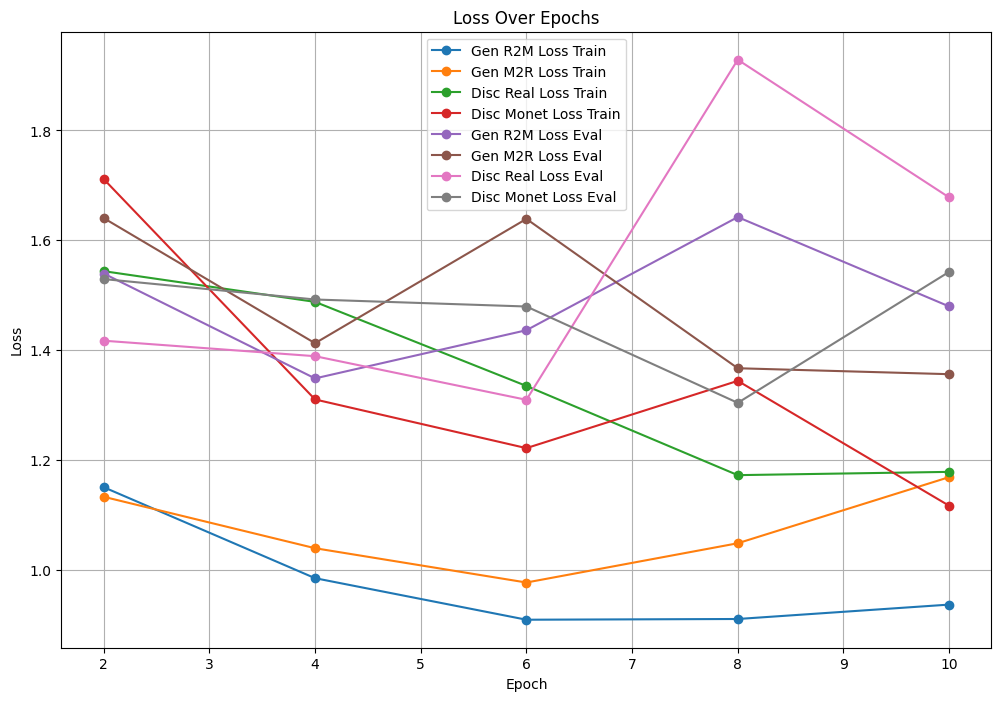

In [72]:
epochs = df_losses['Epoch']
gen_R2M_loss_train = df_losses['Gen R2M Loss Train']
gen_M2R_loss_train = df_losses['Gen M2R Loss Train']
disc_real_loss_train = df_losses['Disc Real Loss Train']
disc_monet_loss_train = df_losses['Disc Monet Loss Train']
gen_R2M_loss_eval = df_losses['Gen R2M Loss Eval']
gen_M2R_loss_eval = df_losses['Gen M2R Loss Eval']
disc_real_loss_eval = df_losses['Disc Real Loss Eval']
disc_monet_loss_eval = df_losses['Disc Monet Loss Eval']

# Plot the data
plt.figure(figsize=(12, 8))

# Plot training loss
plt.plot(epochs, gen_R2M_loss_train, label='Gen R2M Loss Train', marker='o')
plt.plot(epochs, gen_M2R_loss_train, label='Gen M2R Loss Train', marker='o')
plt.plot(epochs, disc_real_loss_train, label='Disc Real Loss Train', marker='o')
plt.plot(epochs, disc_monet_loss_train, label='Disc Monet Loss Train', marker='o')

# Plot evaluation loss
plt.plot(epochs, gen_R2M_loss_eval, label='Gen R2M Loss Eval', marker='o')
plt.plot(epochs, gen_M2R_loss_eval, label='Gen M2R Loss Eval', marker='o')
plt.plot(epochs, disc_real_loss_eval, label='Disc Real Loss Eval', marker='o')
plt.plot(epochs, disc_monet_loss_eval, label='Disc Monet Loss Eval', marker='o')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

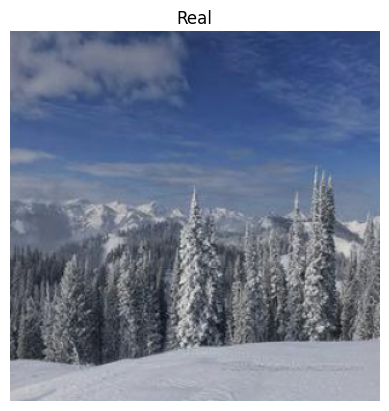

1/1 [==============================] - 0s 156ms/step


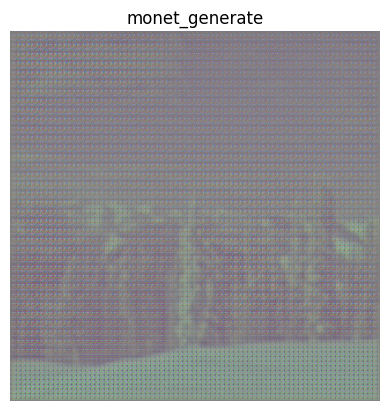

1/1 [==============================] - 0s 170ms/step


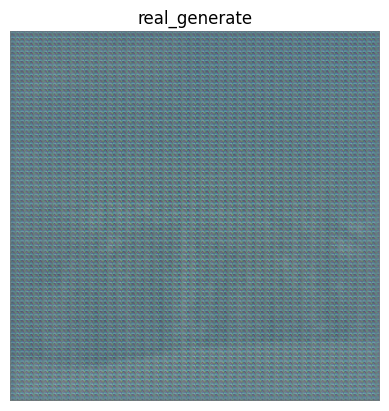

In [76]:
def generate_images(generator, img):
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    generated_img = generator.predict(img)[0]
    return generated_img

best_epoch = 10
models_folder = "models/lr_0.0005_beta_0.5"
generator_real2monet, generator_monet2real = Generator(),Generator()
generator_real2monet.load_weights(os.path.join(models_folder, f'generator_real2monet_epoch_{best_epoch}.h5'))
generator_monet2real.load_weights(os.path.join(models_folder, f'generator_monet2real_epoch_{best_epoch}.h5'))

for real_batch ,monet_batch in test_dataset.take(1):
    real_image = encode_image(real_batch[2])
    plt.imshow(real_image)
    plt.title("Real")
    plt.axis("off")
    plt.show(block = False)

    monet_generate = generate_images(generator_real2monet , real_batch[2])
    monet_generate_img = encode_image(monet_generate)
    plt.imshow(monet_generate_img)
    plt.title("monet_generate")
    plt.axis("off")
    plt.show(block = False)

    real_generate = generate_images(generator_monet2real ,monet_generate)
    real_generate_img = encode_image(real_generate)
    plt.imshow(real_generate_img)
    plt.title("real_generate")
    plt.axis("off")
    plt.show(block = False)